# SCVI in R with Seurat
In this tutorial, we go over how to use scvi-tools in R.

This tutorial requies Reticulate. Please check out our installation [guide](TODO) for instructions on installing Reticulate and scvi-tools from R.

## Loading and Processing Data with Seurat
We follow the basic Seurat [tutorial](https://satijalab.org/seurat/v3.2/pbmc3k_tutorial.html) for loading data and selecting highly variable genes.

**Note: scvi-tools requires raw gene expression**

In [23]:
# We will work within the Seurat framework
library(Seurat)

pbmc.data <- Read10X(data.dir = "/Users/galen/Downloads/filtered_gene_bc_matrices\ 4/hg19/")
pbmc <- CreateSeuratObject(counts = pbmc.data, project = "pbmc3k", min.cells = 3, min.features = 200)
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)
pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 2000)
top2000 <- head(VariableFeatures(pbmc), 2000)
pbmc <- pbmc[top2000]

print(pbmc) # Seurat object

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
2000 features across 2638 samples within 1 assay 
Active assay: RNA (2000 features, 2000 variable features)


## Converting Seurat Object to Anndata

scvi-tools relies on the [AnnData](https://anndata.readthedocs.io/en/latest/) object. Here we show how to convert our Seurat object to anndata for scvi-tools.



In [31]:
library(reticulate)

sc <- import('scanpy', convert = FALSE)
scvi <- import('scvi', convert = FALSE)
scvi.setting.progress_bar_style = 'tqdm'

In [28]:
# convert seurat obj to anndata
adata <- sc$AnnData(
  X   = t(as.matrix(GetAssayData(pbmc))),
  obs = pbmc[[]],
  var = GetAssay(pbmc)[[]]
)
print(adata) # Note generally in Python, dataset conventions are obs x var

AnnData object with n_obs × n_vars = 2638 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'


## Setup our AnnData for Training

Reticulate allows us to call Python code from R, giving the ability to use all of scvi-tools in R. We encourage you to checkout their [documentation](https://rstudio.github.io/reticulate/articles/calling_python.html) and specifically the section on type conversions in order to pass arguments to Python functions.

In this section, we show how to setup the AnnData for scvi-tools, create the model, train the model, and get the latent representation. For a more in depth description of setting up the data, you can checkout our [introductory tutorial](https://www.scvi-tools.org/en/latest/user_guide/notebooks/api_overview.html) as well as our [data loading tutorial](https://www.scvi-tools.org/en/latest/user_guide/notebooks/data_loading.html). 


In [32]:
# run seteup_anndata
scvi$data$setup_anndata(adata)

# create the model
model = scvi$model$SCVI(adata)

# train the model
model$train(n_epochs = as.integer(400))


None

None

## Getting the Latent Represenation and Visualization
Here we get the latent representation of the model and save it back in our Seurat object. Then we run UMAP and visualize. 

In [39]:
# get the latent represenation
latent = model$get_latent_representation()

# put it back in our original Seurat object
latent <- as.matrix(latent)
rownames(latent) = colnames(pbmc)
pbmc[['scvi']] <- CreateDimReducObject(embeddings = latent, key = "scvi_", assay = DefaultAssay(pbmc))


Warning message:
“No columnames present in cell embeddings, setting to 'scvi_1:10'”


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2638
Number of edges: 94933

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8318
Number of communities: 5
Elapsed time: 0 seconds


21:54:25 UMAP embedding parameters a = 0.9922 b = 1.112

21:54:25 Read 2638 rows and found 10 numeric columns

21:54:26 Using Annoy for neighbor search, n_neighbors = 30

21:54:26 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

21:54:26 Writing NN index file to temp file /var/folders/08/l7_h9rq54fn8fs8v2p0yd77w0000gn/T//RtmpiFvWwm/filed54812e688ab

21:54:26 Searching Annoy index using 1 thread, search_k = 3000

21:54:27 Annoy recall = 100%

21:54:27 Commencing smooth kNN distance calibration using 1 thread

21:54:27 Initializing from normalized Laplacian + noise

Spectral initialization failed to converge, using random initialization instead

21:54:27 Commencing optimization for 500 epochs, with 95220 positive edges

21:54:31 Optimization finished



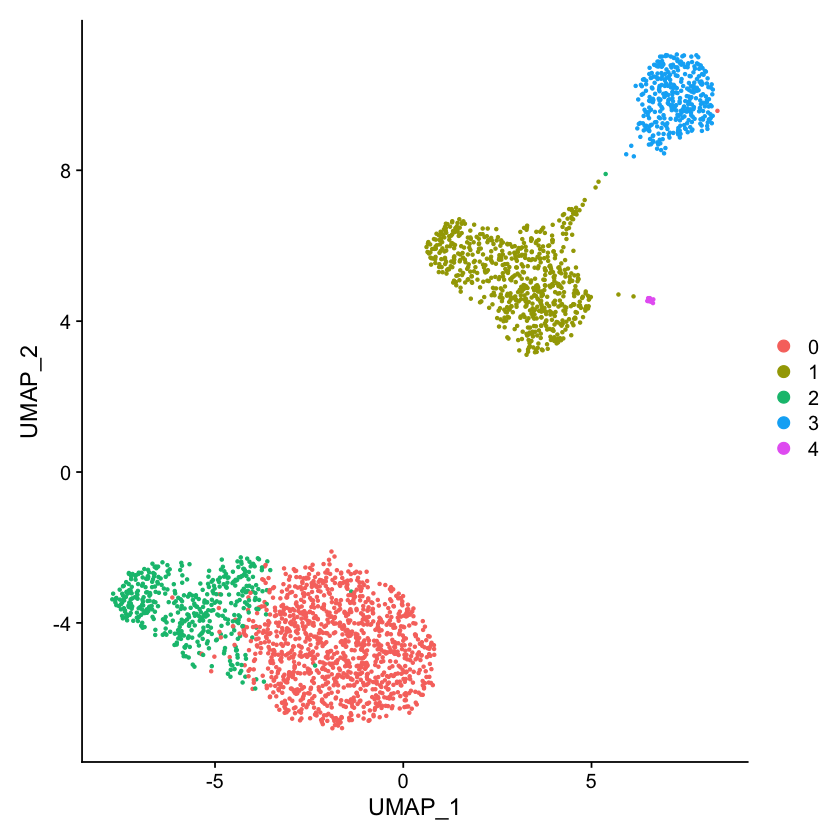

In [42]:
# Find clusters, then run UMAP, and visualize
pbmc <- FindNeighbors(pbmc, dims = 1:10, reduction = 'scvi')
pbmc <- FindClusters(pbmc, resolution = 0.5)

pbmc <- RunUMAP(pbmc, dims = 1:10, reduction = 'scvi', n.components = 2)

DimPlot(pbmc, reduction = "umap")


## Finding differentially expressed genes with SCVI latent space

In [96]:
# we need pandas in order to put the seurat clusters into our original anndata
pd <- import('pandas', convert = FALSE)

# workaround for adding seurat_clusters to our anndata
new_obs <- c(adata$obs, pd$DataFrame(pbmc[['seurat_clusters']]))
new_obs <- pd$concat(new_obs, axis =1)

adata$obs <- new_obs


Using our trained SCVI model, we call the `differential_expression()` method
We pass `seurat_clusters` to the groupby argument and compare between cluster `1` and cluster `2`.

The output of DE is a DataFrame with the bayes factors. Bayes factors > 3 have high probability of being differentially expressed. 

In [109]:
DE <- model$differential_expression(adata, groupby='seurat_clusters', group1 = '1', group2 = '2')

In [110]:
print(DE$head())

      proba_de  proba_not_de  bayes_factor    scale1  ...  non_zeros_proportion2  raw_normalized_mean1  raw_normalized_mean2  comparison
CST3    1.0000        0.0000     18.420681  0.014511  ...               0.193483            160.984711              5.017916   1 vs Rest
TYMP    0.9998        0.0002      8.516943  0.004362  ...               0.148676             43.029976              3.603025   1 vs Rest
FTH1    0.9996        0.0004      7.823621  0.056358  ...               0.986253            670.414001            136.065735   1 vs Rest
LST1    0.9994        0.0006      7.417964  0.006749  ...               0.147658             78.706787              3.815423   1 vs Rest
MAFB    0.9990        0.0010      6.906745  0.000698  ...               0.010183              5.799757              0.198625   1 vs Rest

[5 rows x 17 columns]


## Integrating Datasets with SCVI

Here we reproduce the results from Seurat's [Integration and Label Transfer Vignette](https://satijalab.org/seurat/v3.2/integration.html).

In [113]:
library('SeuratData')
InstallData("ifnb")
data("ifnb")


Registered S3 method overwritten by 'cli':
  method     from    
  print.boxx spatstat



In [157]:
adata <- anndata$AnnData(
  X   = t(as.matrix(GetAssayData(ifnb))),
  obs = ifnb[[]]
)

print(adata)

AnnData object with n_obs × n_vars = 13999 × 14053
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations'


In [182]:
# run seteup_anndata, use column stim for batch
scvi$data$setup_anndata(adata, batch_key = 'stim')

# create the model
model = scvi$model$SCVI(adata)

# train the model
model$train(n_epochs = as.integer(400))


None

None

In [183]:
# get the latent represenation
latent = model$get_latent_representation()

# put it back in our original Seurat object
latent <- as.matrix(latent)
rownames(latent) = colnames(ifnb)
ifnb[['scvi']] <- CreateDimReducObject(embeddings = latent, key = "scvi_", assay = DefaultAssay(ifnb))

Warning message:
“No columnames present in cell embeddings, setting to 'scvi_1:10'”


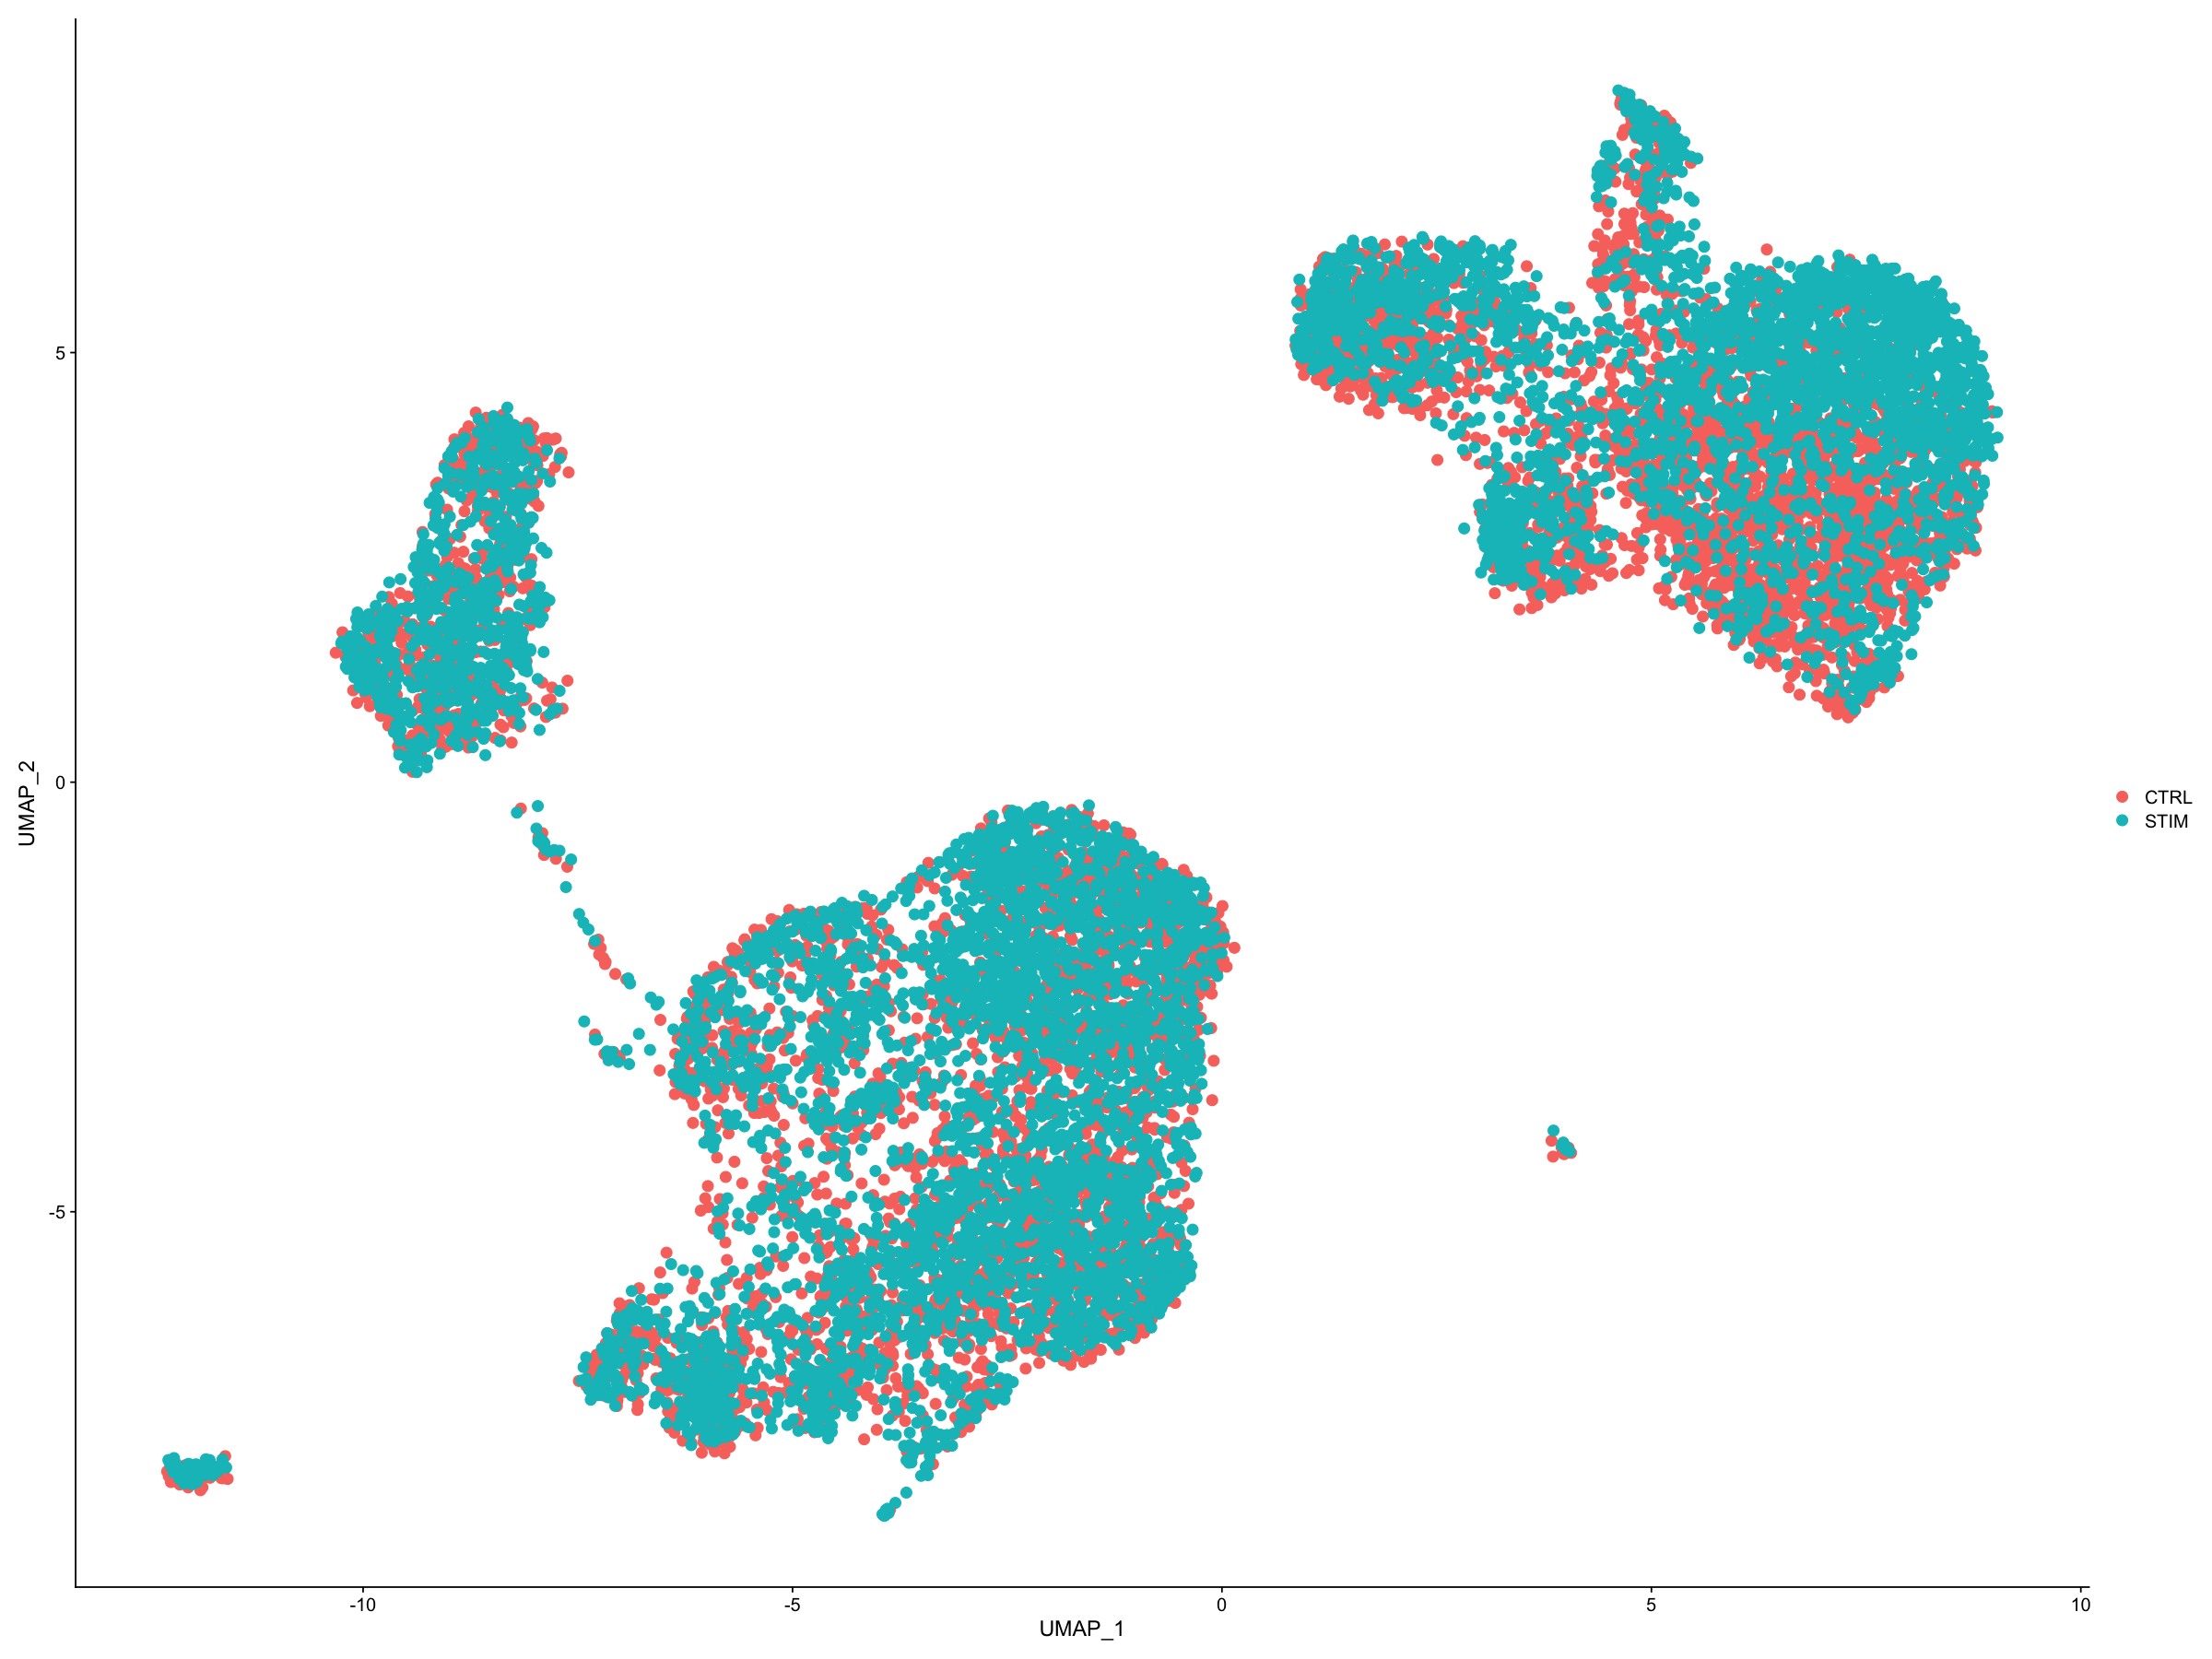

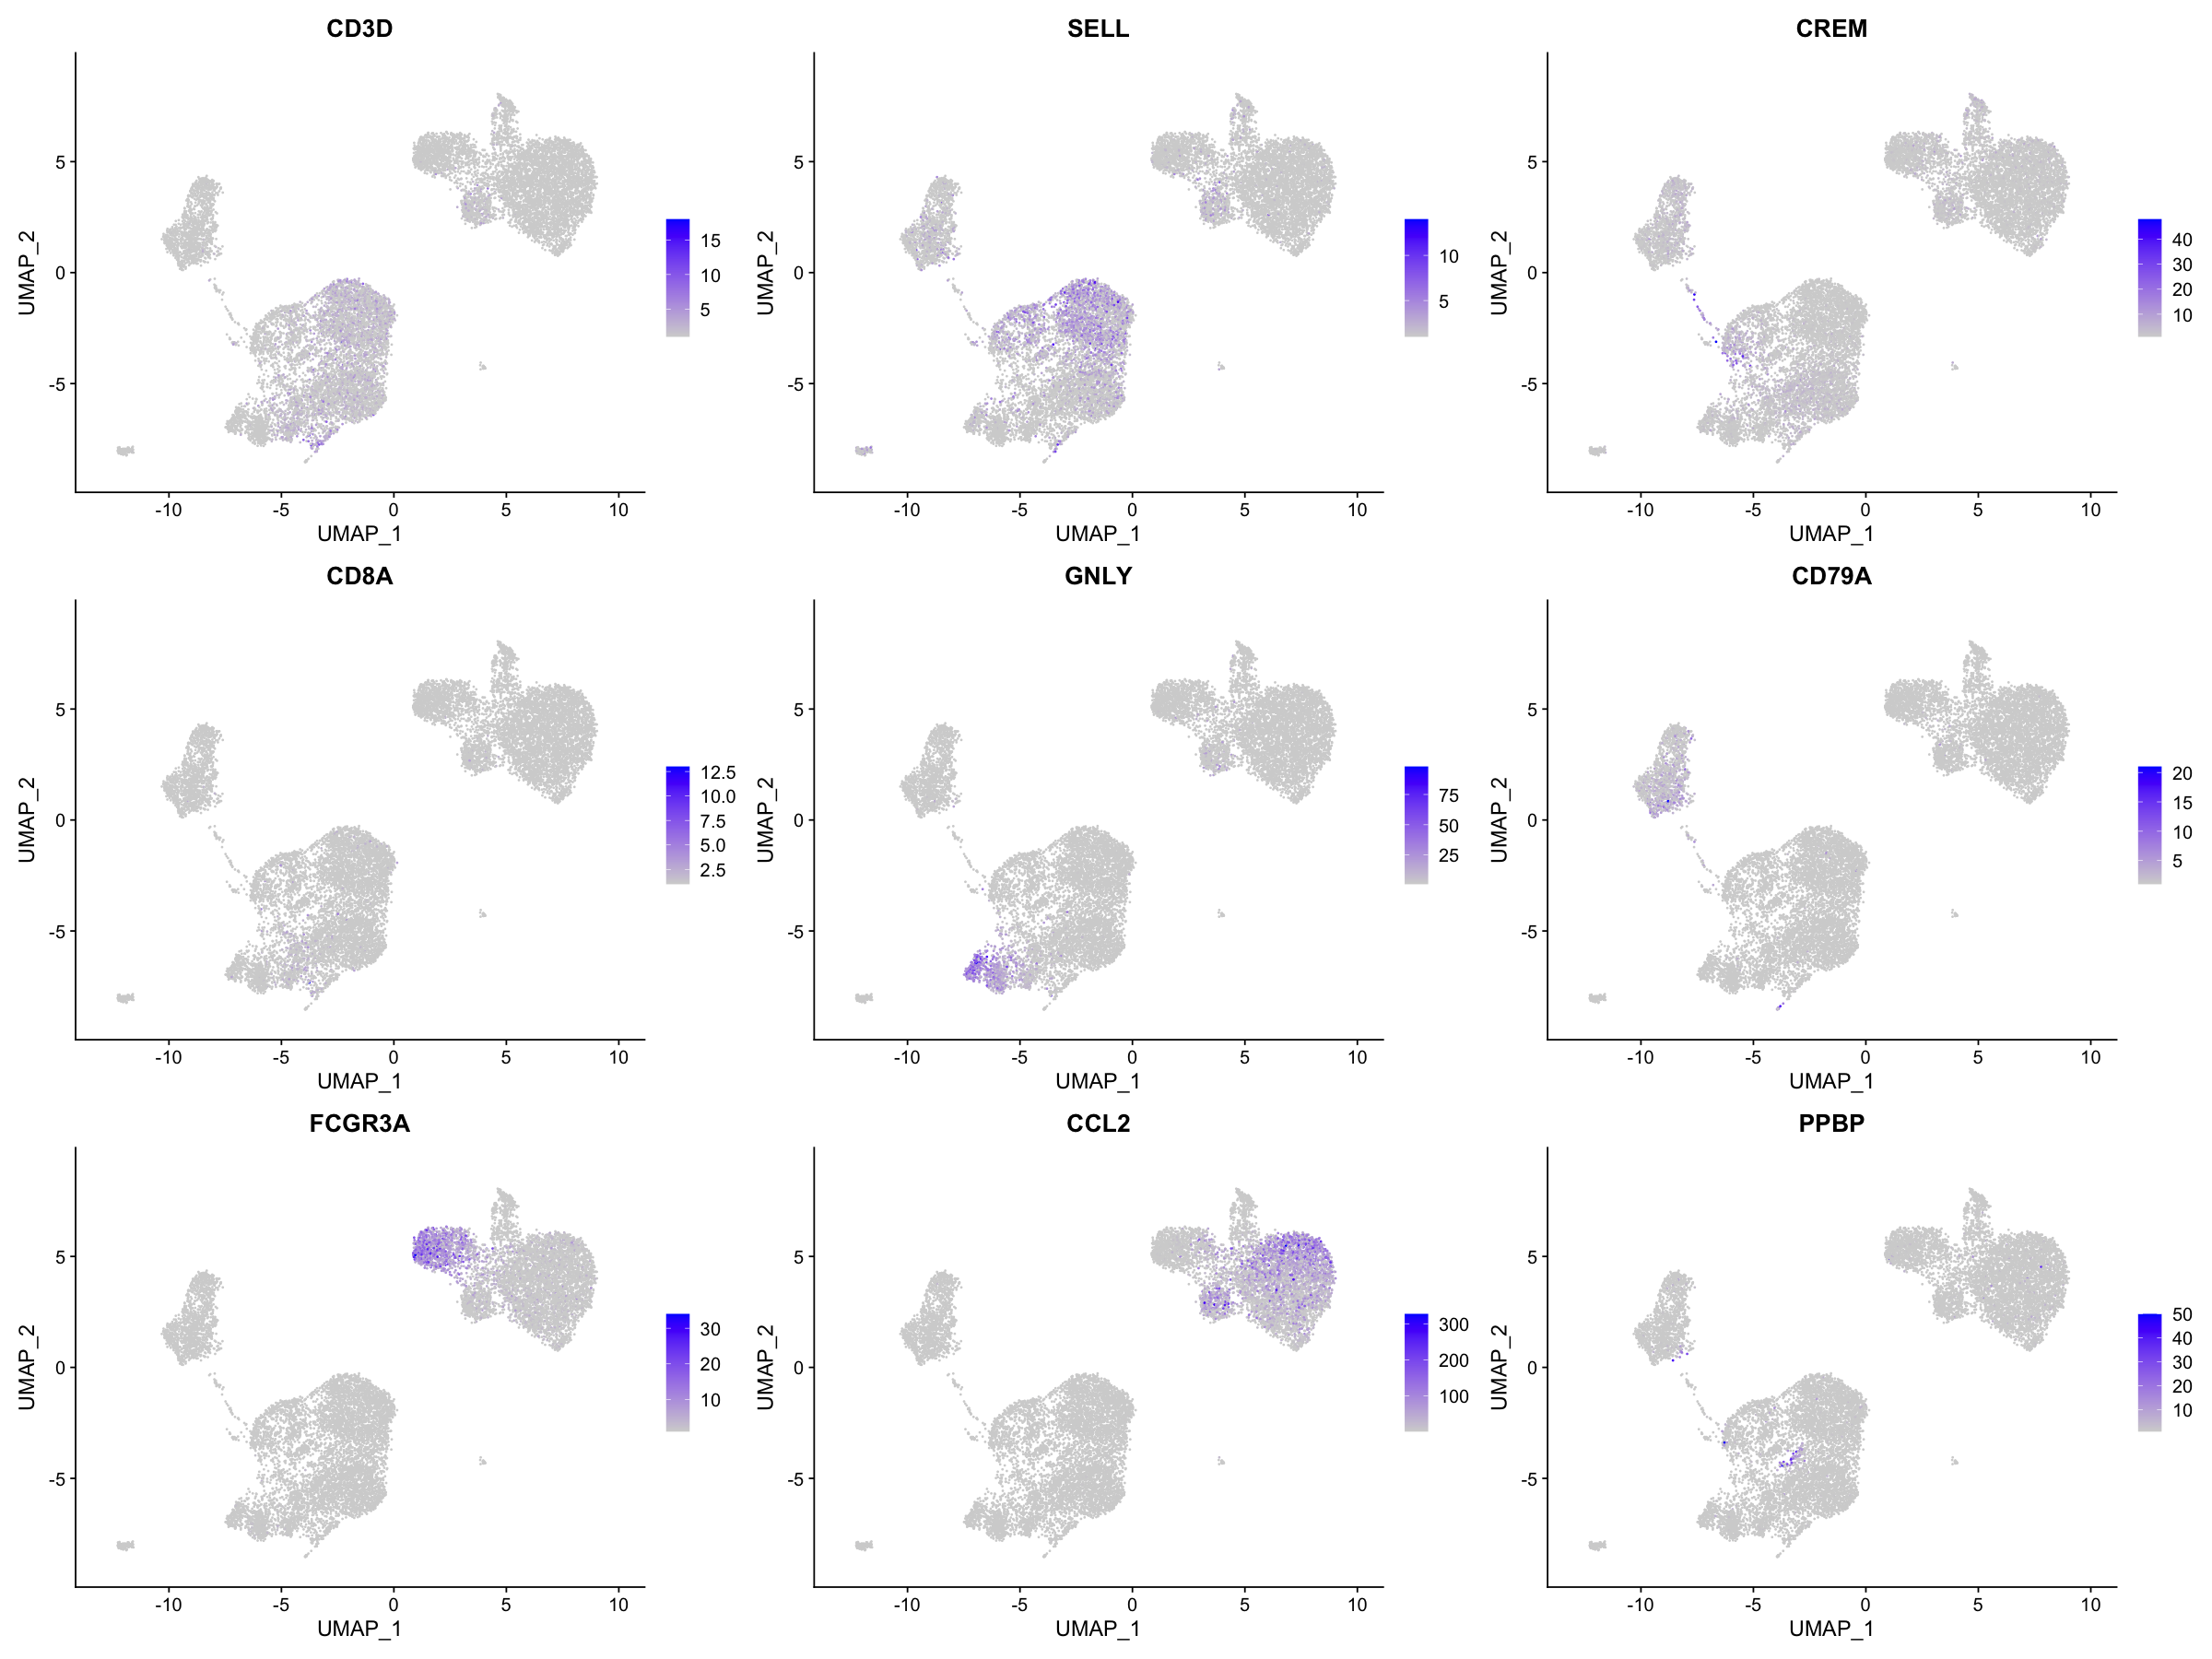

In [185]:
library(cowplot)
# for jupyter notebook
options(repr.plot.width=20, repr.plot.height=15)

ifnb <- RunUMAP(ifnb, dims = 1:10, reduction = 'scvi', n.components = 2)
p1 <- DimPlot(ifnb, reduction = "umap", group.by = "stim", pt.size=3)
plot_grid(p1)

FeaturePlot(ifnb, features = c("CD3D", "SELL", "CREM", "CD8A", "GNLY", "CD79A", "FCGR3A", 
    "CCL2", "PPBP"), min.cutoff = "q9")